# Based on
https://github.com/Fernerkundung/notebooks/blob/master/1D_interpolation.ipynb

In [52]:
# import necessary libraries
import numpy as np
import pandas as pd
#from numba import jit (I haven't installed numba)
import matplotlib.pyplot as plt
import bottleneck
%matplotlib inline

In [84]:
# create example data, original is (644, 4800, 4800)
test_arr =  np.random.uniform(low=-1.0, high=1.0, size=(92, 480, 480)).astype(np.float32)
test_arr[1:90:7, :, :] = np.nan  # NaN fill value in original data
test_arr[2,:,:] = np.nan
test_arr[:, 1:479:6, 1:479:8] = np.nan

In [85]:
def interpolate_nan(arr, method="linear", limit=3):
    """return array interpolated along time-axis to fill missing values"""
    result = np.zeros_like(arr, dtype=np.float32)

    for i in range(arr.shape[1]):
        # slice along y axis, interpolate with pandas wrapper to interp1d
        line_stack = pd.DataFrame(data=arr[:,i,:], dtype=np.float32)
        line_stack.interpolate(method=method, axis=0, inplace=True, limit=limit)
        result[:, i, :] = line_stack.values.astype(np.float32)
    return result

In [86]:
def interpolate_bottleneck(arr, inplace=True, window=3, min_count=1, axis=0):
    means = bottleneck.move_mean(arr, window, min_count, axis)
    nans = np.isnan(arr)
    if inplace:
        arr[nans] = means[nans]
        return arr
    else:
        result = np.copy(arr)
        nans = np.isnan(arr)
        result[nans] = means[nans]
        return result

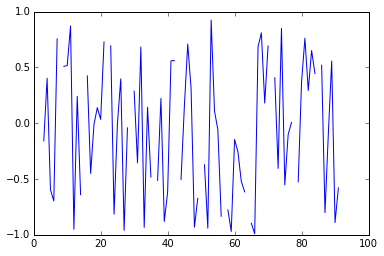

In [93]:
# show the example time-series at location (:,3,4)
plt.plot(test_arr[:,3,4])

In [94]:
result = interpolate_bottleneck(test_arr, False)

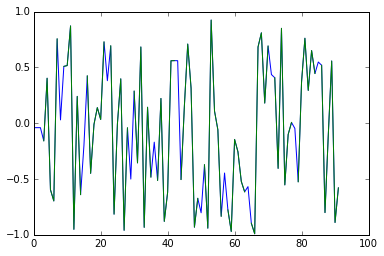

In [95]:
plt.plot(result[:,3,4])
plt.plot(test_arr[:,3,4])

# Some timings

In [96]:
#Straight bottleneck calculation of the windowed means, no filling of nans in input array
%timeit bottleneck.move_mean(test_arr, window=3, min_count=1, axis=0)

1 loops, best of 3: 303 ms per loop


In [97]:
#filling of nans in copy of array
%timeit interpolate_bottleneck(test_arr, inplace=False)

1 loops, best of 3: 419 ms per loop


In [98]:
#filling of nans in array in place
test_copy = np.copy(test_arr)
%timeit interpolate_bottleneck(test_copy)

1 loops, best of 3: 355 ms per loop


In [61]:
#Original 1D interpolation
%timeit interpolate_nan(test_arr)

1 loops, best of 3: 50.5 s per loop
